In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,  cross_val_predict, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 

In [2]:
# Creating DataFrames with tblROUND_MATCH_PLAYER
server = 'tcp:timjoo01.database.windows.net'
database = 'ESports_Fantasy'
username = 'timjoo01_Admin'
password = 'GoDawgs!'
driver = '{ODBC Driver 17 for SQL Server}'

cnxn_rounds = pyodbc.connect('DRIVER=' + driver +
';SERVER=' + server +
';DATABASE=' + database +
';UID=' + username +
';PWD=' + password)

rounds = pd.read_sql_query('SELECT RMP.*, R.RankName FROM tblPLAYER P JOIN tblROUND_MATCH_PLAYER RMP ON RMP.PlayerID = P.PlayerID JOIN tblRANK R ON R.RankID = P.RankID', cnxn_rounds)

In [3]:
# Creating DataFrames with tblPLAYER
server = 'tcp:timjoo01.database.windows.net'
database = 'ESports_Fantasy'
username = 'timjoo01_Admin'
password = 'GoDawgs!'
driver = '{ODBC Driver 17 for SQL Server}'

cnxn_players = pyodbc.connect('DRIVER=' + driver +
';SERVER=' + server +
';DATABASE=' + database +
';UID=' + username +
';PWD=' + password)

players = pd.read_sql_query('SELECT * FROM tblPLAYER', cnxn_players)

In [4]:
server = 'tcp:timjoo01.database.windows.net'
database = 'ESports_Fantasy'
username = 'timjoo01_Admin'
password = 'GoDawgs!'
driver = '{ODBC Driver 17 for SQL Server}'

cnxn_teams = pyodbc.connect('DRIVER=' + driver +
';SERVER=' + server +
';DATABASE=' + database +
';UID=' + username +
';PWD=' + password)

teams = pd.read_sql_query('SELECT P.PlayerName, R.RankName, RMP.RoundID, RMP.Score, RMP.Kills, RMP.Deaths, RMP.Assists, RMP.Plants, RMP.Defuses FROM tblPLAYER P JOIN tblROUND_MATCH_PLAYER RMP ON RMP.PlayerID = P.PlayerID JOIN tblRANK R ON R.RankID = P.RankID', cnxn_teams)


In [5]:
teams.head()

,PlayerName,RankName,RoundID,Score,Kills,Deaths,Assists,Plants,Defuses
0,hippotwig,Immortal 1,1,284,1,0,1,0,0
1,ravenjuzo,Immortal 3,1,707,3,0,0,0,0
2,Subby,Diamond 1,1,0,0,1,0,0,0
3,murata fan,Gold 1,1,250,1,0,0,1,0
4,taro tea,Gold 3,1,0,0,1,0,0,0


In [6]:
rounds.head()

,RoundMatchPlayerID,RoundID,PlayerID,MatchID,Score,Kills,Deaths,Assists,Plants,Defuses,RankName
0,1,1,1,1,284,1,0,1,0,0,Immortal 1
1,2,1,2,1,707,3,0,0,0,0,Immortal 3
2,3,1,3,1,0,0,1,0,0,0,Diamond 1
3,4,1,4,1,250,1,0,0,1,0,Gold 1
4,5,1,5,1,0,0,1,0,0,0,Gold 3


In [8]:
players.head()

,PlayerID,PlayerName,TagLine,RankID
0,1,hippotwig,3489,19
1,2,ravenjuzo,777,21
2,3,Subby,dommy,16
3,4,murata fan,4444,10
4,5,taro tea,uwu,12


# Data Cleanups

In [9]:
# Converting column names into snake casing.
teams.columns = [col.replace(' ', ',').lower() for col in teams.columns]
rounds.columns = [col.replace(' ', ',').lower() for col in rounds.columns]
players.columns = [col.replace(' ', ',').lower() for col in players.columns]

# Since the dataset is imported in through an organized tournament
# there are no null values.
# We do not need to delete any rows.

In [10]:
# checking the rounds dataframe
pd.set_option('display.max_columns', None)
rounds.groupby(['playerid']).describe()

roundmatchplayerid                                                \
                      count        mean         std    min     25%    50%   
playerid                                                                    
1                      65.0  162.415385   94.831247    1.0   81.00  164.0   
2                      65.0  163.061538   95.299016    2.0   82.00  163.0   
3                      65.0  174.600000  138.344543    3.0   83.00  165.0   
4                      65.0  161.876923   93.458799    4.0   84.00  161.0   
5                      65.0  163.230769   93.859564    5.0   85.00  162.0   
6                      34.0  407.500000   49.791231  325.0  366.25  407.5   
7                      34.0  408.500000   49.791231  326.0  367.25  408.5   
8                      34.0  409.500000   49.791231  327.0  368.25  409.5   
9                      34.0  410.500000   49.791231  328.0  369.25  410.5   
10                     34.0  426.029412  110.121279  329.0  370.25  411.5   
11                     35.0  579.000000   51.234754  494.0  536.50  579.0   
12                     35.0  580.000000   51.234754  495.0  537.50  580.0   
13                     35.0  581.000000   51.234754  496.0  538.50  581.0   
14                     35.0  582.000000   51.234754  497.0  539.50  582.0   
15                     35.0  592.171429   84.699637  498.0  540.50  583.0   
16                     64.0  826.984375   94.790076  668.0  746.75  825.5   
17                     64.0  827.578125   93.850236  669.0  747.75  827.5   
18                     64.0  827.140625   92.247229  670.0  748.75  828.5   
19                     64.0  828.140625   92.247229  671.0  749.75  829.5   
20                     64.0  827.703125   92.443664  672.0  750.75  826.5   

                        roundid                                              \
             75%    max   count       mean       std  min  25%   50%    75%   
playerid                                                                      
1         242.00  322.0    65.0  11.415385  6.432079  1.0  6.0  11.0  17.00   
2         244.00  324.0    65.0  11.415385  6.432079  1.0  6.0  11.0  17.00   
3         245.00  987.0    65.0  11.415385  6.432079  1.0  6.0  11.0  17.00   
4         241.00  321.0    65.0  11.415385  6.432079  1.0  6.0  11.0  17.00   
5         243.00  323.0    65.0  11.415385  6.432079  1.0  6.0  11.0  17.00   
6         448.75  490.0    34.0   9.029412  5.024095  1.0  5.0   9.0  13.00   
7         449.75  491.0    34.0   9.029412  5.024095  1.0  5.0   9.0  13.00   
8         450.75  492.0    34.0   9.029412  5.024095  1.0  5.0   9.0  13.00   
9         451.75  493.0    34.0   9.029412  5.024095  1.0  5.0   9.0  13.00   
10        452.75  988.0    34.0   9.029412  5.024095  1.0  5.0   9.0  13.00   
11        621.50  664.0    35.0   9.314286  5.228718  1.0  5.0   9.0  13.50   
12        622.50  665.0    35.0   9.314286  5.228718  1.0  5.0   9.0  13.50   
13        623.50  666.0    35.0   9.314286  5.228718  1.0  5.0   9.0  13.50   
14        624.50  667.0    35.0   9.314286  5.228718  1.0  5.0   9.0  13.50   
15        625.50  989.0    35.0   9.314286  5.228718  1.0  5.0   9.0  13.50   
16        908.25  990.0    64.0  11.296875  6.411002  1.0  6.0  11.0  16.25   
17        907.25  986.0    64.0  11.296875  6.411002  1.0  6.0  11.0  16.25   
18        904.25  983.0    64.0  11.296875  6.411002  1.0  6.0  11.0  16.25   
19        905.25  984.0    64.0  11.296875  6.411002  1.0  6.0  11.0  16.25   
20        906.25  985.0    64.0  11.296875  6.411002  1.0  6.0  11.0  16.25   

               matchid                                              score  \
           max   count      mean       std  min  25%  50%  75%  max count   
playerid                                                                    
1         23.0    65.0  3.476923  1.659327  1.0  1.0  4.0  5.0  5.0  65.0   
2         23.0    65.0  3.476923  1.659327  1.0  1.0  4.0  5.0  5.0  65.0   
3         23.0    65.0  3.476923  

# Data Visualizations

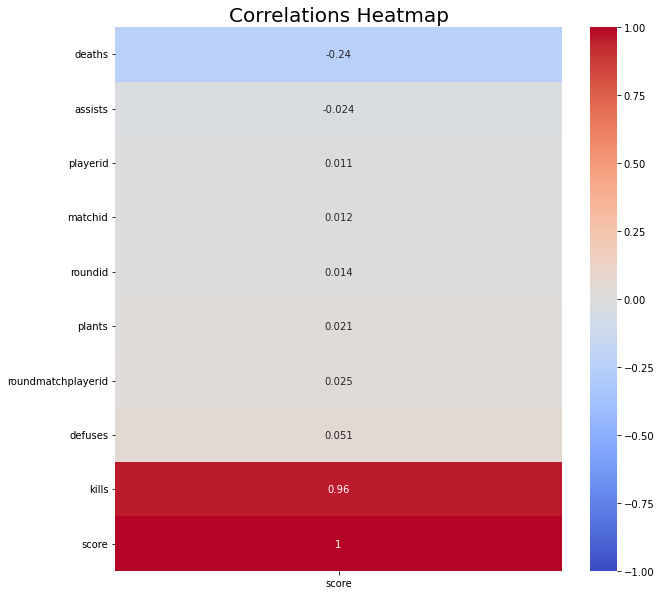

In [11]:
# Correlations Heatmap
plt.figure(figsize=(10,10))
plt.title('Correlations Heatmap', fontsize=20)
sns.heatmap(rounds.corr()[['score']].sort_values('score'),
annot=True,
cmap='coolwarm',
vmin=-1,
vmax=1);


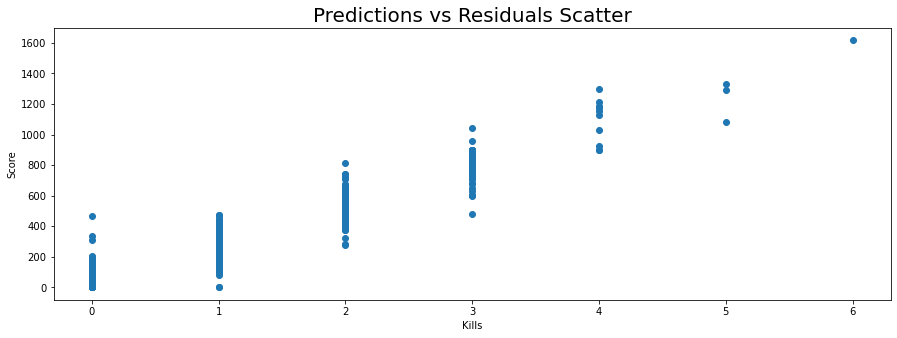

In [12]:
# Scatter Plot of Kills vs Score
plt.figure(figsize=(15,5))
plt.title('Predictions vs Residuals Scatter', fontsize=20)
plt.xlabel('Kills')
plt.ylabel('Score')
plt.scatter(x = rounds['kills'], y = rounds['score']);

In [14]:
# Train test split
features = ['kills', 'deaths', 'assists', 'plants', 'defuses']
X = rounds[features]
y = rounds['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [15]:
# linear regression
sc = StandardScaler()
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9334065059789914, 0.9129102020215192)

In [16]:
# Scaled
lr_sc = LinearRegression()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

lr_sc.fit(X_train_sc, y_train)
lr_sc.score(X_train_sc, y_train), lr_sc.score(X_test_sc, y_test)

(0.9334065059789914, 0.9129102020215193)

When scaling, it did not improve our linear regression model. It was a miniscule increase in our test score. Therefore, there was not much reason to choose one over another.

# Checking our model

First, we need to see what score is needed to work with. We can calculate by finding the mean of the baseline score in the 'y_test'.

In [17]:
# Baseline Score
baseline= y_test - y_test.mean()
rounds['baseline'] =  y_test.mean()
rmse_baseline = mean_squared_error(rounds['score'], rounds['baseline'], squared=False)
rmse_baseline

250.43178752325446

The root mean score of the average baseline score is 250.43. Now, we would need to see if the model we made can make better predictions than the mean.

In [19]:
# Root Squared Error

rounds['lr_preds'] = lr.predict(rounds[features])
rmse = mean_squared_error(rounds['score'], rounds['lr_preds'], squared=False)
rmse

65.8987561856856

Since the model is better than the overal mean of the data, we can conclude that the this linear regression model is viable for predicting the future scores when given the features.

# Random Forest Regressor

In [20]:
rf = RandomForestRegressor(random_state=42)
cross_val_score(rf, X_train, y_train).mean(), cross_val_score(rf, X_test, y_test).mean()

(0.9247912899252781, 0.9027716323727697)

In [21]:
# Grid Searching
params={}
gs=GridSearchCV(RandomForestRegressor(random_state=42), param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)


0.9247912899252781


In [22]:
rounds['rf_preds'] = gs.predict(rounds[features])
rmse_rf = mean_squared_error(rounds['score'], rounds['rf_preds'], squared=False)
rmse_rf

61.20442614562135

The Root Mean Squared Error is better for the random forest Regressor model than the linear regression model.

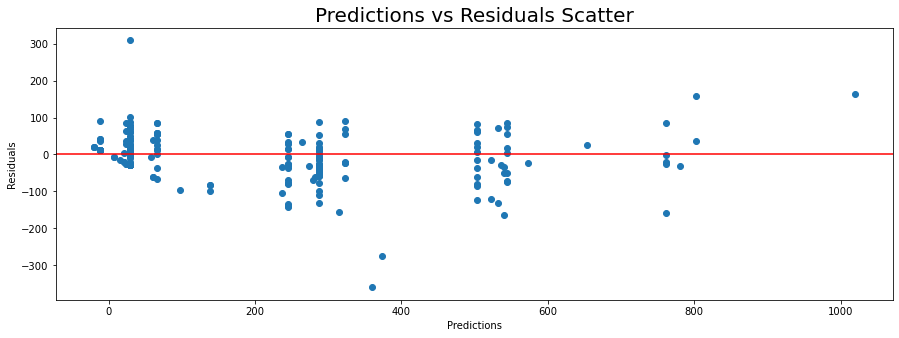

In [23]:
# Plotting Residuals vs Predictions
predictions = lr.predict(X_test)
residuals = y_test - predictions
plt.figure(figsize=(15,5))
plt.title('Predictions vs Residuals Scatter', fontsize=20)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.scatter(x=predictions, y=residuals)
plt.axhline(0, color='r');

Residual values are calculated by subtracting the dependent or observed values by the predicted. To see if it is good model we would need to check if the scatter plot is random.

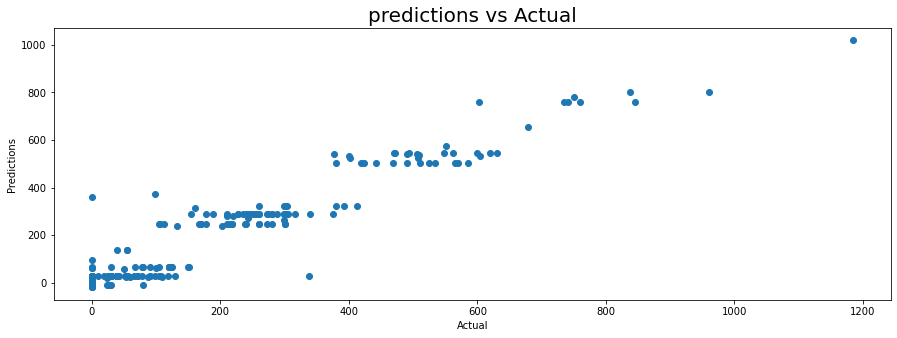

In [24]:
# Plotting Predictions vs Actual
plt.figure(figsize=(15,5))
plt.title('predictions vs Actual', fontsize=20)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.scatter(x=y_test, y=predictions);

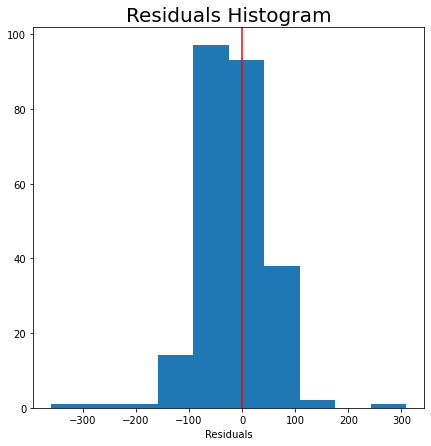

In [25]:
# Residuals Histogram
plt.figure(figsize=(7,7))
plt.title('Residuals Histogram', fontsize=20)
plt.xlabel('Residuals')
plt.axvline(0, color='r')
plt.hist(residuals);

When looking at the residuals histogram, the graph looks like it is more left skewed with the mode slightly to the left.

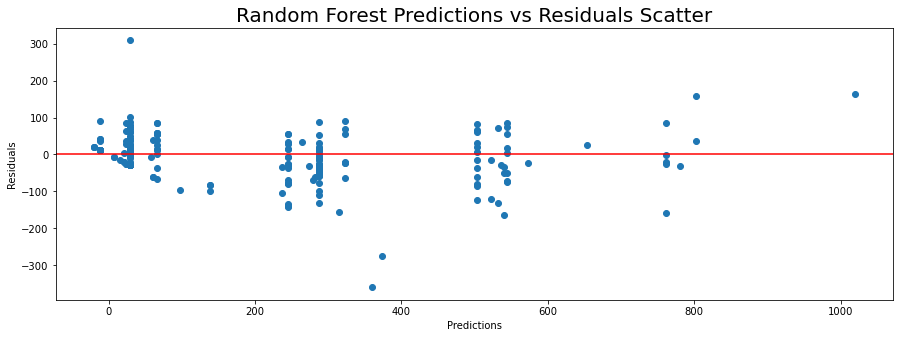

In [26]:
# Plotting Residuals vs Predictions
predictions_rf = gs.predict(X_test)
residuals_rf = y_test - predictions_rf

plt.figure(figsize=(15,5))
plt.title('Random Forest Predictions vs Residuals Scatter', fontsize=20)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.scatter(x=predictions, y=residuals)
plt.axhline(0, color='r');

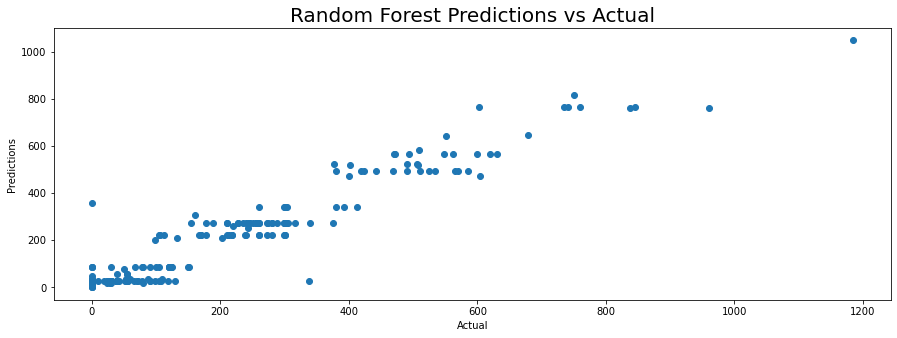

In [27]:
# Plotting Predictions vs Actual
plt.figure(figsize=(15,5))
plt.title('Random Forest Predictions vs Actual', fontsize=20)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.scatter(x=y_test, y=predictions_rf);

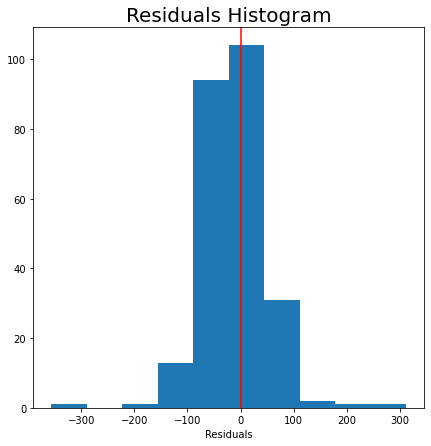

In [28]:
# Residuals Histogram
plt.figure(figsize=(7,7))
plt.title('Residuals Histogram', fontsize=20)
plt.xlabel('Residuals')
plt.axvline(0, color='r')
plt.hist(residuals_rf);

Compared to the histogram of the linear regression model, the random forest regressor seems more evenly distributed. The mode of the graph is closer to the origin.

# Summary

If there were more time, it would have been useful to get the more features to predict our score such as 'damage dealt per round'. This information is one of the features needed to calculate the total score.

Score is calculated by a couple performances: 1 point for each damage dealt, kills depending on how much health they have, multi-kills, non-damaging assists such as abilities, and rounds won. Because our data had not given us the damage dealt using guns nor abilities, we could not get a better score for our linear regression. Since this is a fantasy scoring linear regression, we do not need it to be in the feature to calculate the scores. To reduce the root mean squared error, it would be better for the model itself. In this instance I would not use it. When looking at the correlation heatmap graph, we are able to see how the negative impact the insufficient data impacts the overall data.

Knowing if there were more time, there would be more improvements to be made. For example, the dataset could be more complete. Although the dataset was enough to work with, it did not have a feature that contributes to the score. Knowing that there is an API page, requests were made to gather the complete API JSON file, the page was not accessible. Another change to consider is the time series implementation. This is a suggestion for future to give a better prediction. Just like Fantasy football or fantasy basketball, the scores change during the game. So, to make the project more interactive, time series is needed."